In [1]:
import pandas as pd
import os
import json

data_dir = '../data/triviaqa-unfiltered/'
file_names = ['unfiltered-web-dev.json', 'unfiltered-web-train.json']
data_list = []

for file_name in file_names:
    file_path = os.path.join(data_dir, file_name)
    with open(file_path, 'r') as f:
        json_data = json.load(f)
        for item in json_data["Data"]:
            answer = item["Answer"]["Value"]
            question = item["Question"]
            question_id = item["QuestionId"]
            question_source = item["QuestionSource"]
            
            search_results = []
            for result in item["SearchResults"]:
                search_results.append({
                    "Description": result.get("Description", ""),
                    "DisplayUrl": result.get("DisplayUrl", ""),
                    "Rank": result.get("Rank", ""),
                    "Title": result.get("Title", ""),
                    "Url": result.get("Url", "")
                })
            
            data_list.append({
                "Answer": answer,
                "Question": question,
                "QuestionId": question_id,
                "QuestionSource": question_source,
                "SearchResults": search_results
            })

df = pd.DataFrame(data_list)
df

,Answer,Question,QuestionId,QuestionSource,SearchResults
0,David Seville,Who was the man behind The Chipmunks?,tc_2,http://www.triviacountry.com/,[{'Description': 'Alice Cooper's The Man Behin...
1,Scorpio,What star sign is Jamie Lee Curtis?,tc_13,http://www.triviacountry.com/,"[{'Description': 'Jamie Lee Curtis, Actress: T..."
2,Sunset Boulevard,Which Lloyd Webber musical premiered in the US...,tc_33,http://www.triviacountry.com/,[{'Description': 'The official website for And...
3,Campbell-Bannerman,Who was the next British Prime Minister after ...,tc_40,http://www.triviacountry.com/,[{'Description': 'The history and complete tex...
4,Exile,Who had a 70s No 1 hit with Kiss You All Over?,tc_49,http://www.triviacountry.com/,[{'Description': '... credits and award inform...
...,...,...,...,...,...
98930,Rock Lobster by the B-52s,Name the artist and the title of this 1978 cla...,qg_4644,https://quizguy.wordpress.com/,[{'Description': 'Under a Rock. Posted 7.11.11...
98931,Bugs Bunny,"July 27, 1940 saw the introduction of what bel...",qg_4646,https://quizguy.wordpress.com/,"[{'Description': 'Bugs Bunny Is 75, And Now Yo..."
98932,All the kings horses and all the kings men,"According to the nursery rhyme, who couldnt pu...",qg_4647,https://quizguy.wordpress.com/,[{'Description': 'Couldn't put Humpty together...
98933,Harpy,With a name that translates as that which snat...,qg_4649,https://quizguy.wordpress.com/,[{'Description': 'Good Reads Books which I hav...


In [5]:
num_questions = df.shape[0]

df['QuestionLength'] = df['Question'].apply(lambda x: len(x.split()))
avg_question_length = df['QuestionLength'].mean()
std_question_length = df['QuestionLength'].std()

df['NumContexts'] = df['SearchResults'].apply(lambda x: len(x))
num_contexts = df['NumContexts'].sum()

df['ContextLength'] = df['SearchResults'].apply(lambda x: sum(len(result['Description'].split()) for result in x))
avg_context_length = df['ContextLength'].mean()
std_context_length = df['ContextLength'].std()

df['AnswerLength'] = df['Answer'].apply(lambda x: len(x.split()))
avg_answer_length = df['AnswerLength'].mean()
std_answer_length = df['AnswerLength'].std()

print(f"Number of questions: {num_questions}")
print(f"Average question length: {avg_question_length:.2f} words")
print(f"Standard deviation of question length: {std_question_length:.2f} words")
print(f"Number of contexts (facts): {num_contexts}")
print(f"Average context length: {avg_context_length:.2f} words")
print(f"Standard deviation of context length: {std_context_length:.2f} words")
print(f"Average golden answer length: {avg_answer_length:.2f} words")
print(f"Standard deviation of golden answer length: {std_answer_length:.2f} words")

Number of questions: 98935
Average question length: 13.99 words
Standard deviation of question length: 7.02 words
Number of contexts (facts): 4509392
Average context length: 1231.78 words
Standard deviation of context length: 232.92 words
Average golden answer length: 1.96 words
Standard deviation of golden answer length: 1.72 words


In [2]:
import nltk
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm

nltk.download('punkt')

def get_top_ngrams(questions, n, top_k=32):
    ngram_counter = Counter()
    for question in questions:
        tokens = nltk.word_tokenize(question.lower())
        ngram_counter.update(ngrams(tokens, n))
    return ngram_counter.most_common(top_k)

questions = df['Question'].tolist()

df_ngram = pd.DataFrame(columns=[f'rank-{i+1}' for i in range(32)], index=[f'{i+1}-gram' for i in range(8)])

for n in tqdm(range(1, 9), desc="Processing n-grams"):
    top_ngrams = get_top_ngrams(questions, n)
    for rank, (ngram, freq) in enumerate(top_ngrams):
        ngram_str = ' '.join(ngram)
        df_ngram.at[f'{n}-gram', f'rank-{rank+1}'] = (ngram_str, freq)
    print(f"Top {n}-grams: {top_ngrams[:5]}")
    df_ngram.to_csv('top_ngrams.csv', index=True)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/yuehengzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing n-grams:   0%|          | 0/8 [00:00<?, ?it/s]

Top 1-grams: [(('the',), 110024), (('?',), 93887), (('of',), 54478), (('in',), 53302), ((',',), 50083)]
Top 2-grams: [(('of', 'the'), 15389), (('is', 'the'), 14583), (('in', 'the'), 12299), (('what', 'is'), 9637), (('was', 'the'), 8608)]
Top 3-grams: [(('what', 'is', 'the'), 7576), (('the', 'name', 'of'), 3552), (("''", '?', "''"), 3118), (("''", "''", '?'), 3113), (('name', 'of', 'the'), 3040)]
Top 4-grams: [(("''", "''", '?', "''"), 3098), (('the', 'name', 'of', 'the'), 2575), (('what', 'is', 'the', 'name'), 2188), (('is', 'the', 'name', 'of'), 1871), (('what', 'was', 'the', 'name'), 1309)]
Top 5-grams: [(('what', 'is', 'the', 'name', 'of'), 1819), (('is', 'the', 'name', 'of', 'the'), 1486), (('what', 'was', 'the', 'name', 'of'), 1243), (('was', 'the', 'name', 'of', 'the'), 987), (('what', 'name', 'is', 'given', 'to'), 628)]
Top 6-grams: [(('what', 'is', 'the', 'name', 'of', 'the'), 1457), (('what', 'was', 'the', 'name', 'of', 'the'), 969), (('what', 'name', 'is', 'given', 'to', 'the

/tmp/ipykernel_2823410/3794144559.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2823410/3794144559.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2823410/3794144559.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2823410/3794144559.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2823410/3794144559.py:32: UserWarning: set_ticklabels() should on

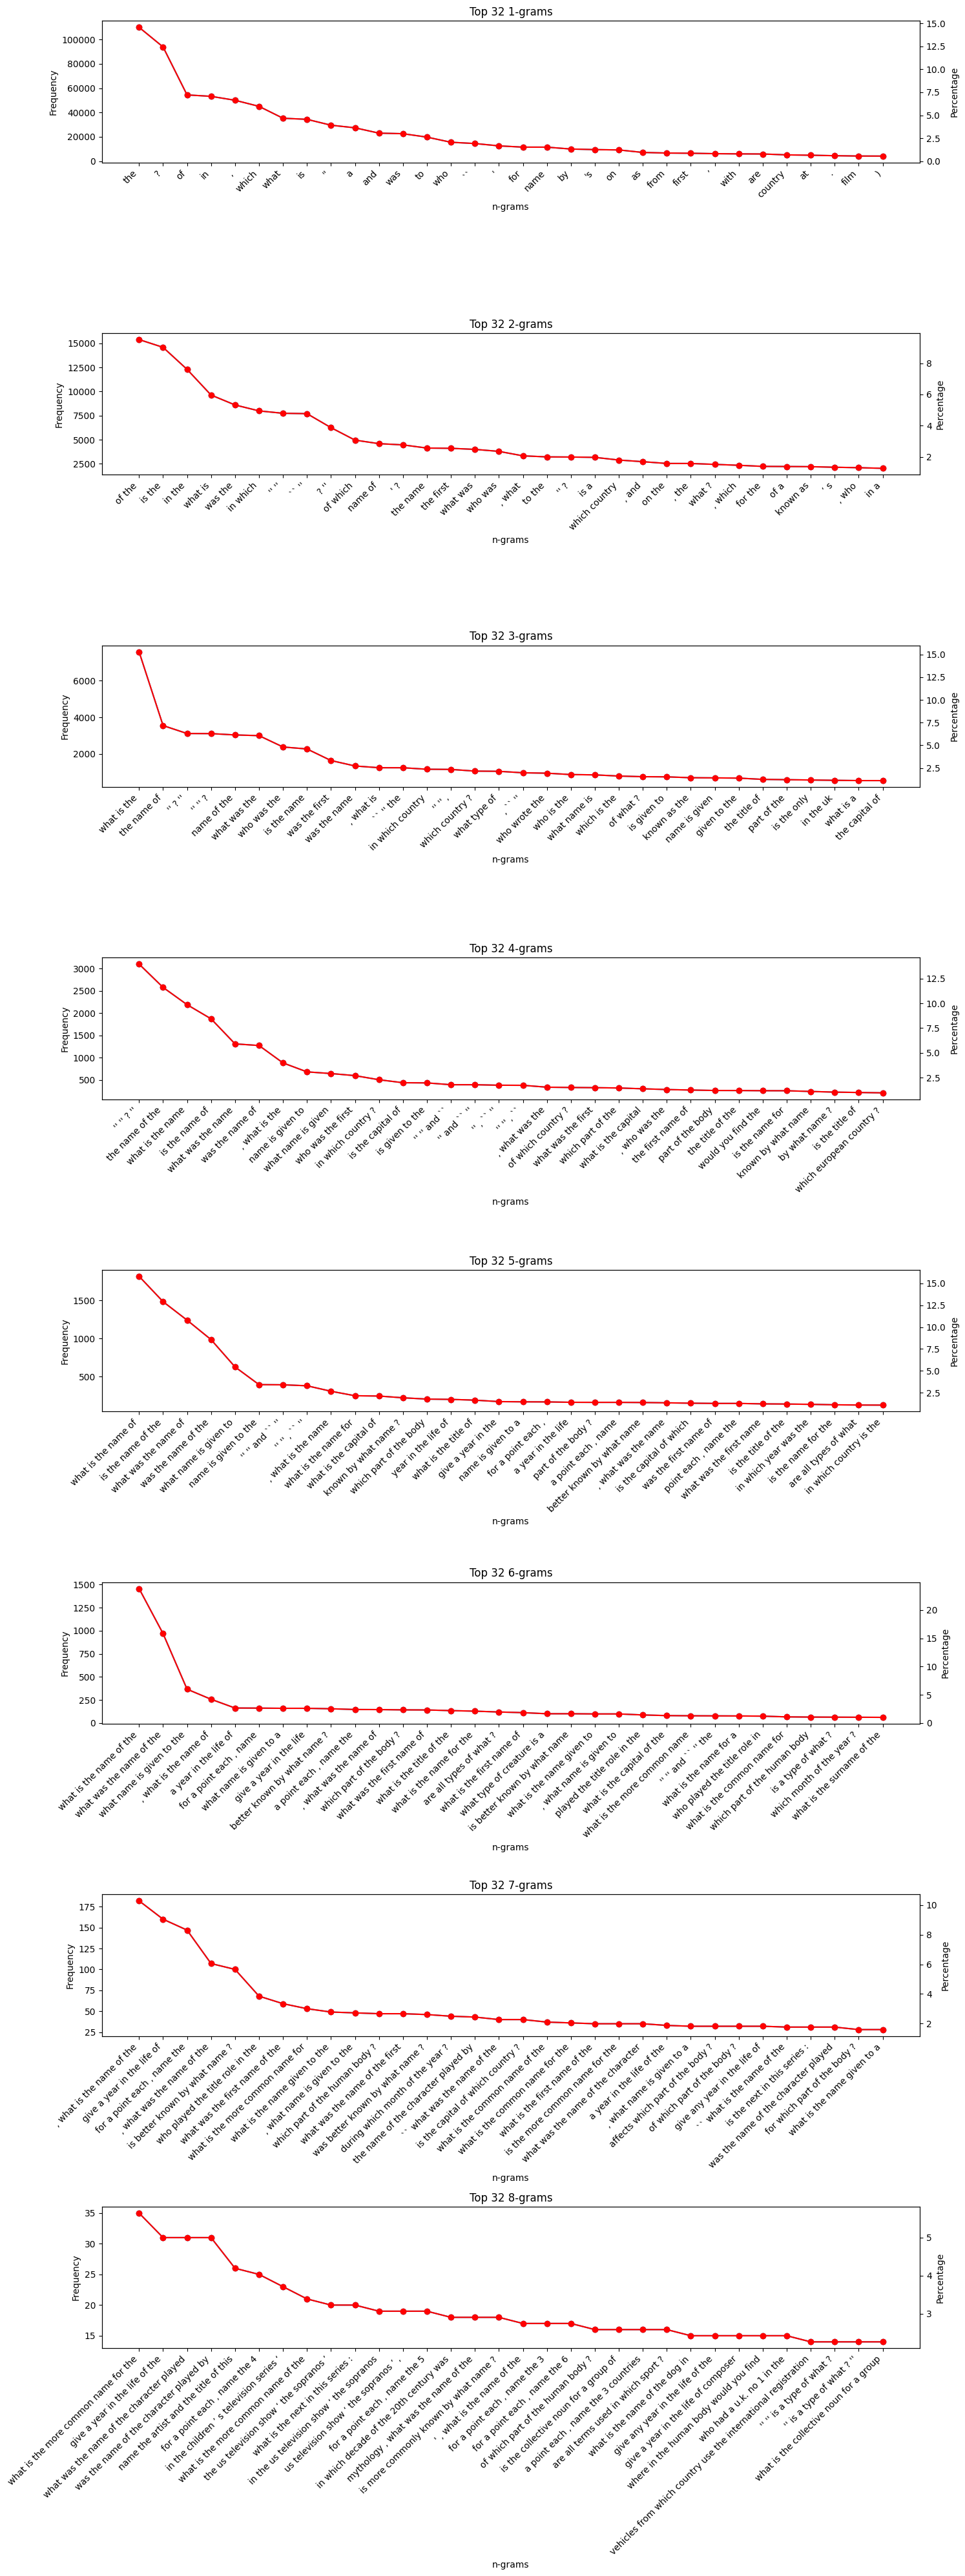

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df_ngram = pd.read_csv('top_ngrams.csv', index_col=0)
def parse_ngram_freq(cell):
    if isinstance(cell, str):
        ngram, freq = eval(cell)
        return ngram, freq
    return None, 0

fig, axs = plt.subplots(8, 1, figsize=(15, 40))

for i in range(8):
    n = i + 1
    ngram_labels = []
    frequencies = []
    
    for col in df_ngram.columns:
        ngram, freq = parse_ngram_freq(df_ngram.at[f'{n}-gram', col])
        if ngram:
            ngram_labels.append(ngram)
            frequencies.append(freq)

    total_freq = sum(frequencies)
    ratios = [freq / total_freq * 100 for freq in frequencies]
    
    ax1 = axs[i]
    ax1.plot(ngram_labels, frequencies, marker='o', label='Frequency')
    ax1.set_title(f'Top 32 {n}-grams')
    ax1.set_xlabel('n-grams')
    ax1.set_ylabel('Frequency')
    ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
    
    ax2 = ax1.twinx()
    ax2.plot(ngram_labels, ratios, marker='o', color='r', label='Percentage')
    ax2.set_ylabel('Percentage')

plt.tight_layout()
plt.show()